In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os, cv2
import glob as gb
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
import keras
from keras.layers import Dropout
from keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from transformers import TFAutoModel, AutoTokenizer


ModuleNotFoundError: No module named 'transformers'

In [3]:
# Loaing dataset in collab  from kaggle
!pip install opendatasets
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: menamuhammad
Your Kaggle Key: ··········
Your Kaggle Key: ··········


100%|██████████| 385M/385M [00:07<00:00, 52.9MB/s]


In [5]:
# Define paths for train and test folders
pathTrain = '/content/cards-image-datasetclassification/train'
pathTest = '/content/cards-image-datasetclassification/test'

In [6]:
# Size of images
s = 200

# Encode/ Labelize y data
code = {'ace of clubs': 0, 'ace of diamonds': 1, 'ace of hearts': 2, 'ace of spades': 3, 'eight of clubs': 4, 'eight of diamonds': 5, 'eight of hearts': 6, 'eight of spades': 7, 'five of clubs': 8, 'five of diamonds': 9, 'five of hearts': 10, 'five of spades': 11, 'four of clubs': 12, 'four of diamonds': 13, 'four of hearts': 14, 'four of spades': 15, 'jack of clubs': 16, 'jack of diamonds': 17, 'jack of hearts': 18, 'jack of spades': 19, 'joker': 20, 'king of clubs': 21, 'king of diamonds': 22, 'king of hearts': 23, 'king of spades': 24, 'nine of clubs': 25, 'nine of diamonds': 26, 'nine of hearts': 27, 'nine of spades': 28, 'queen of clubs': 29, 'queen of diamonds': 30, 'queen of hearts': 31, 'queen of spades': 32, 'seven of clubs': 33, 'seven of diamonds': 34, 'seven of hearts': 35, 'seven of spades': 36, 'six of clubs': 37, 'six of diamonds': 38, 'six of hearts': 39, 'six of spades': 40, 'ten of clubs': 41, 'ten of diamonds': 42, 'ten of hearts': 43, 'ten of spades': 44, 'three of clubs': 45, 'three of diamonds': 46, 'three of hearts': 47, 'three of spades': 48, 'two of clubs': 49, 'two of diamonds': 50, 'two of hearts': 51, 'two of spades': 52}

In [7]:
# Declare train data
X_train = []
y_train = []
y_train_labels = []
# Loop over the folder
for folder in  os.listdir(pathTrain) : 
    # Open each folder inside
    for file in os.listdir(pathTrain+'/'+folder):
        # Scan the images inside
        image = cv2.imread(pathTrain +'/' + folder + '/' + file)
        # resize the images 
        image_array = cv2.resize(image , (s,s))
        # categorize the data in lists
        X_train.append(list(image_array))
        y_train.append(code[folder])
        y_train_labels.append(folder)

print(f'We have {len(X_train)} items in X_train and {len(y_train)} in y_train')

We have 7624 items in X_train and 7624 in y_train


In [8]:
# Declare test data
X_test = []
y_test = []
y_test_labels = []

# Loop over the folder
for folder in os.listdir(pathTest):
    # Open each folder inside
    for file in os.listdir(pathTest+f'/{folder}'):
        # Scan the images inside
        image = cv2.imread(pathTest +'/' + folder + '/' + file)
        # resize the images 
        image_array = cv2.resize(image , (s,s))
        # categorize the data in lists
        X_test.append(list(image_array))
        y_test.append(code[folder])
        y_test_labels.append(folder)
        
print(f'We have {len(X_test)} items in X_test and {len(y_test)} in y_test')

We have 265 items in X_test and 265 in y_test


In [9]:
# Have a look at the shapes of train and test data
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

X_train shape  is (7624, 200, 200, 3)
X_test shape  is (265, 200, 200, 3)
y_train shape  is (7624,)
y_test shape  is (265,)


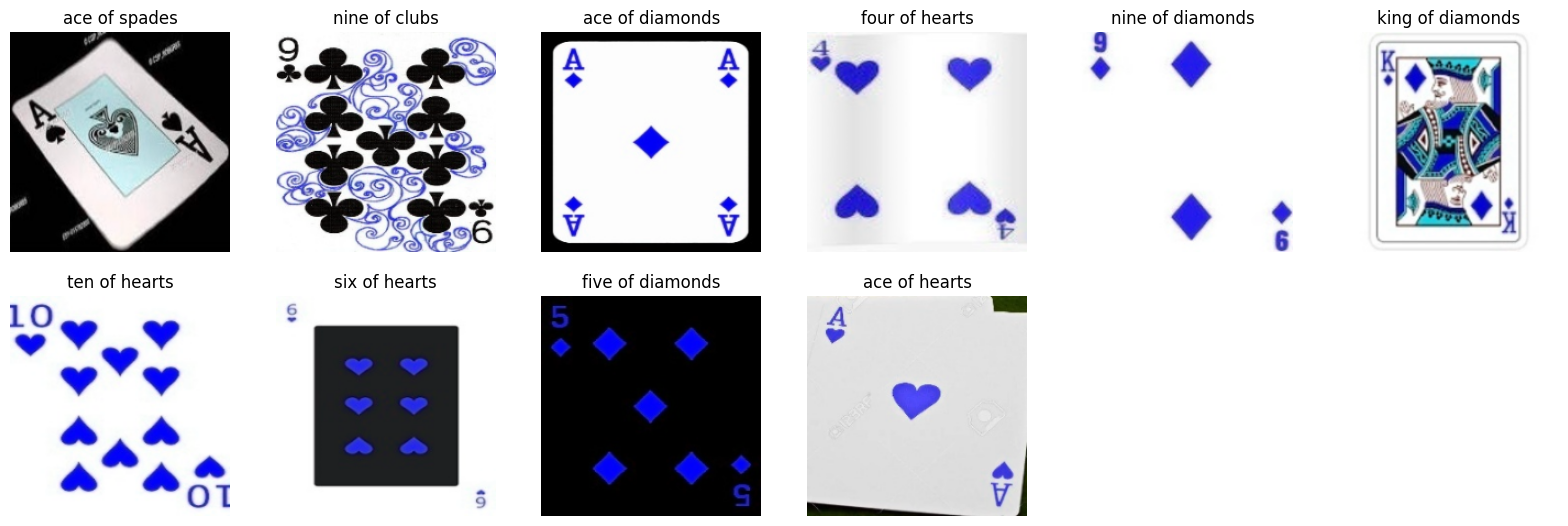

In [10]:
# Show random part of the images
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),10))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i])   
    plt.axis('off')
    plt.title(y_train_labels[i])

In [11]:
# Define the data augmentation parameters
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=lambda x: x/255.0      # normalizes the pixel values of the images to a range of [0, 1]
)

datagen_test = ImageDataGenerator(
    preprocessing_function=lambda x: x/255.0
)

In [24]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(s, s, 3))

# Freeze the layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add a few layers on top of the pre-trained model for classification
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(53, activation='softmax'))

In [13]:
# Define the input shape of your model
input_shape = (s, s, 3)

In [36]:
# Define the data generators for the training and test images
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_directory(
        pathTrain,
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='binary')

datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_directory(
        pathTest,
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='binary')

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [38]:
# create the model
Model = keras.Sequential()
for layer in base_model.layers[:-1]:
    Model.add(layer)

Model.add(keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=input_shape))
Model.add(keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'))
Model.add(keras.layers.MaxPool2D(4,4))
Model.add(keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu', padding='same'))
Model.add(keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu', padding='same'))
Model.add(keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu', padding='same'))
Model.add(keras.layers.MaxPool2D(4,4, padding='same'))
Model.add(keras.layers.Flatten())
Model.add(keras.layers.Dense(120,activation='relu'))
Model.add(keras.layers.Dense(100,activation='relu'))
Model.add(keras.layers.Dense(50,activation='relu'))
Model.add(Dropout(rate=0.5))
Model.add(keras.layers.Dense(53,activation='softmax'))

# Compile your model with appropriate optimizer and loss function
Model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Train your model on the training data
History = Model.fit(train_generator, epochs=20
                    , validation_data=test_generator)

Epoch 1/20
239/239 [==============================] - 37s 137ms/step - loss: 3.8184 - accuracy: 0.0333 - val_loss: 3.5500 - val_accuracy: 0.0491
Epoch 2/20
239/239 [==============================] - 30s 124ms/step - loss: 3.4165 - accuracy: 0.0643 - val_loss: 2.8430 - val_accuracy: 0.1057
Epoch 3/20
239/239 [==============================] - 31s 128ms/step - loss: 3.0108 - accuracy: 0.1081 - val_loss: 2.5800 - val_accuracy: 0.1585
Epoch 4/20
239/239 [==============================] - 30s 127ms/step - loss: 2.7382 - accuracy: 0.1554 - val_loss: 2.3736 - val_accuracy: 0.2038
Epoch 5/20
239/239 [==============================] - 33s 137ms/step - loss: 2.5135 - accuracy: 0.1946 - val_loss: 2.1249 - val_accuracy: 0.2755
Epoch 6/20
239/239 [==============================] - 31s 128ms/step - loss: 2.3301 - accuracy: 0.2365 - val_loss: 2.0199 - val_accuracy: 0.2943
Epoch 7/20
239/239 [==============================] - 30s 126ms/step - loss: 2.2133 - accuracy: 0.2685 - val_loss: 2.0672 - val_ac

In [41]:
'''
# Create the CNN model
Model = keras.models.Sequential([
        keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=input_shape),
        keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Flatten() ,    
        keras.layers.Dense(120,activation='relu') ,    
        keras.layers.Dense(100,activation='relu') ,    
        keras.layers.Dense(50,activation='relu') ,        
        keras.layers.Dropout(rate=0.5) ,            
        keras.layers.Dense(53,activation='softmax') ,    
        ])

# Compile your model with appropriate optimizer and loss function
Model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Train your model on the training data
History = Model.fit(train_generator, epochs=20
                    , validation_data=test_generator)
'''

"\n# Create the CNN model\nModel = keras.models.Sequential([\n        keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=input_shape),\n        keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),\n        keras.layers.MaxPool2D(4,4),\n        keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),    \n        keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),    \n        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),\n        keras.layers.MaxPool2D(4,4),\n        keras.layers.Flatten() ,    \n        keras.layers.Dense(120,activation='relu') ,    \n        keras.layers.Dense(100,activation='relu') ,    \n        keras.layers.Dense(50,activation='relu') ,        \n        keras.layers.Dropout(rate=0.5) ,            \n        keras.layers.Dense(53,activation='softmax') ,    \n        ])\n\n# Compile your model with appropriate optimizer and loss function\nModel.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',

In [39]:
Model.save('/content/cards-image-datasetclassification/')

In [40]:
# model = keras.models.load_model('/content/cards-image-datasetclassification')

In [42]:
y_pred = Model.predict(X_test)
print('Prediction Shape is {}'.format(y_pred.shape))

9/9 [==============================] - 1s 112ms/step
Prediction Shape is (265, 53)


In [43]:
# Show how each prediction is
print(y_pred[0])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.1780719e-32 1.3032687e-16 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.3150570e-35 1.4207415e-24 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.3249610e-06 9.9999869e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]


In [44]:
# getting the predictions ready to show
y_pred_labels = []
y_pred_final = []
# loop over each one of y prediction
for i in y_pred:
  # Get the result as it's the maximum probabilty of the 53 neurons
  index = np.argmax(i)
  # Get the lables for each number
  pred = list(code.keys())[list(code.values()).index(index)]
  y_pred_final.append(i)
  y_pred_labels.append(pred)

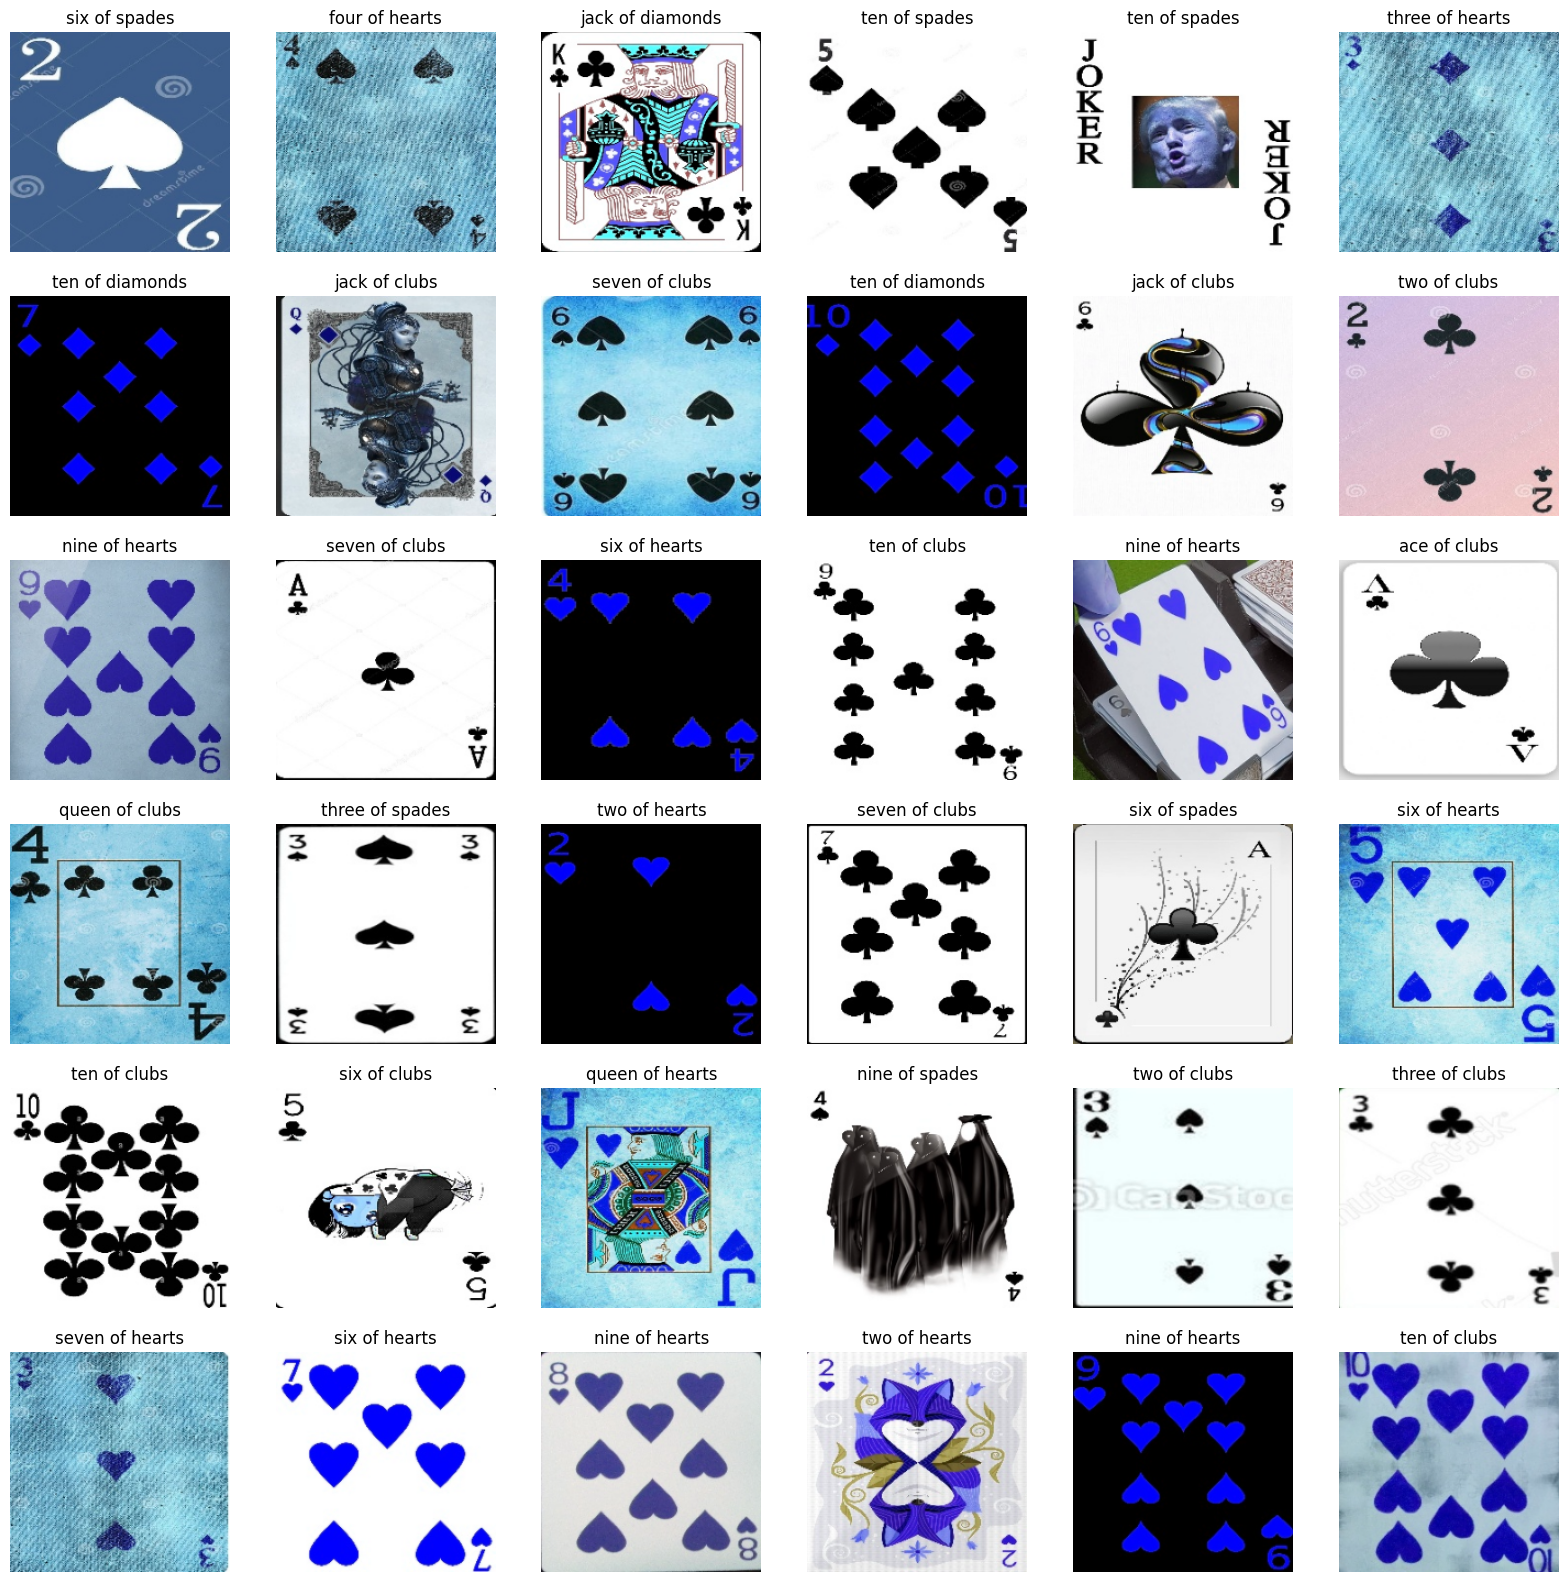

In [45]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_test),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_test[i])    
    plt.axis('off')
    plt.title(y_pred_labels[i])

In [46]:
print(History.history.keys())
accuracy = History.history['accuracy']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


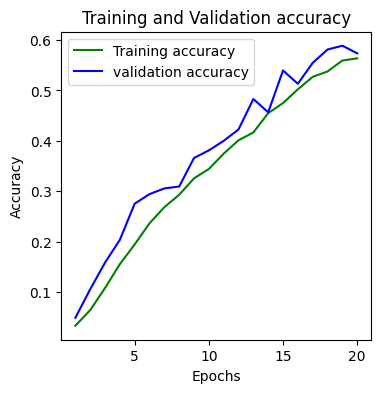

In [47]:
# showing the accuracy for training and validation
acc_train = History.history['accuracy']
acc_val = History.history['val_accuracy']
epochs = range(1,21)
plt.rcParams['figure.figsize'] = [4, 4]
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

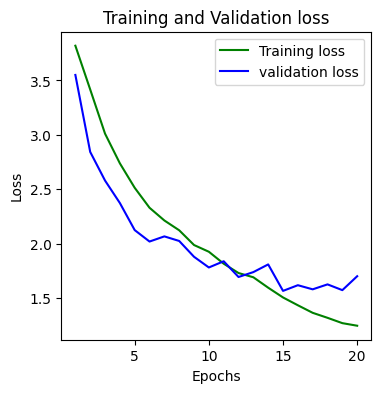

In [48]:
# showing the loss for training and validation
loss_train = History.history['loss']
loss_val = History.history['val_loss']
epochs = range(1, 21)
plt.rcParams['figure.figsize'] = [4, 4]
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

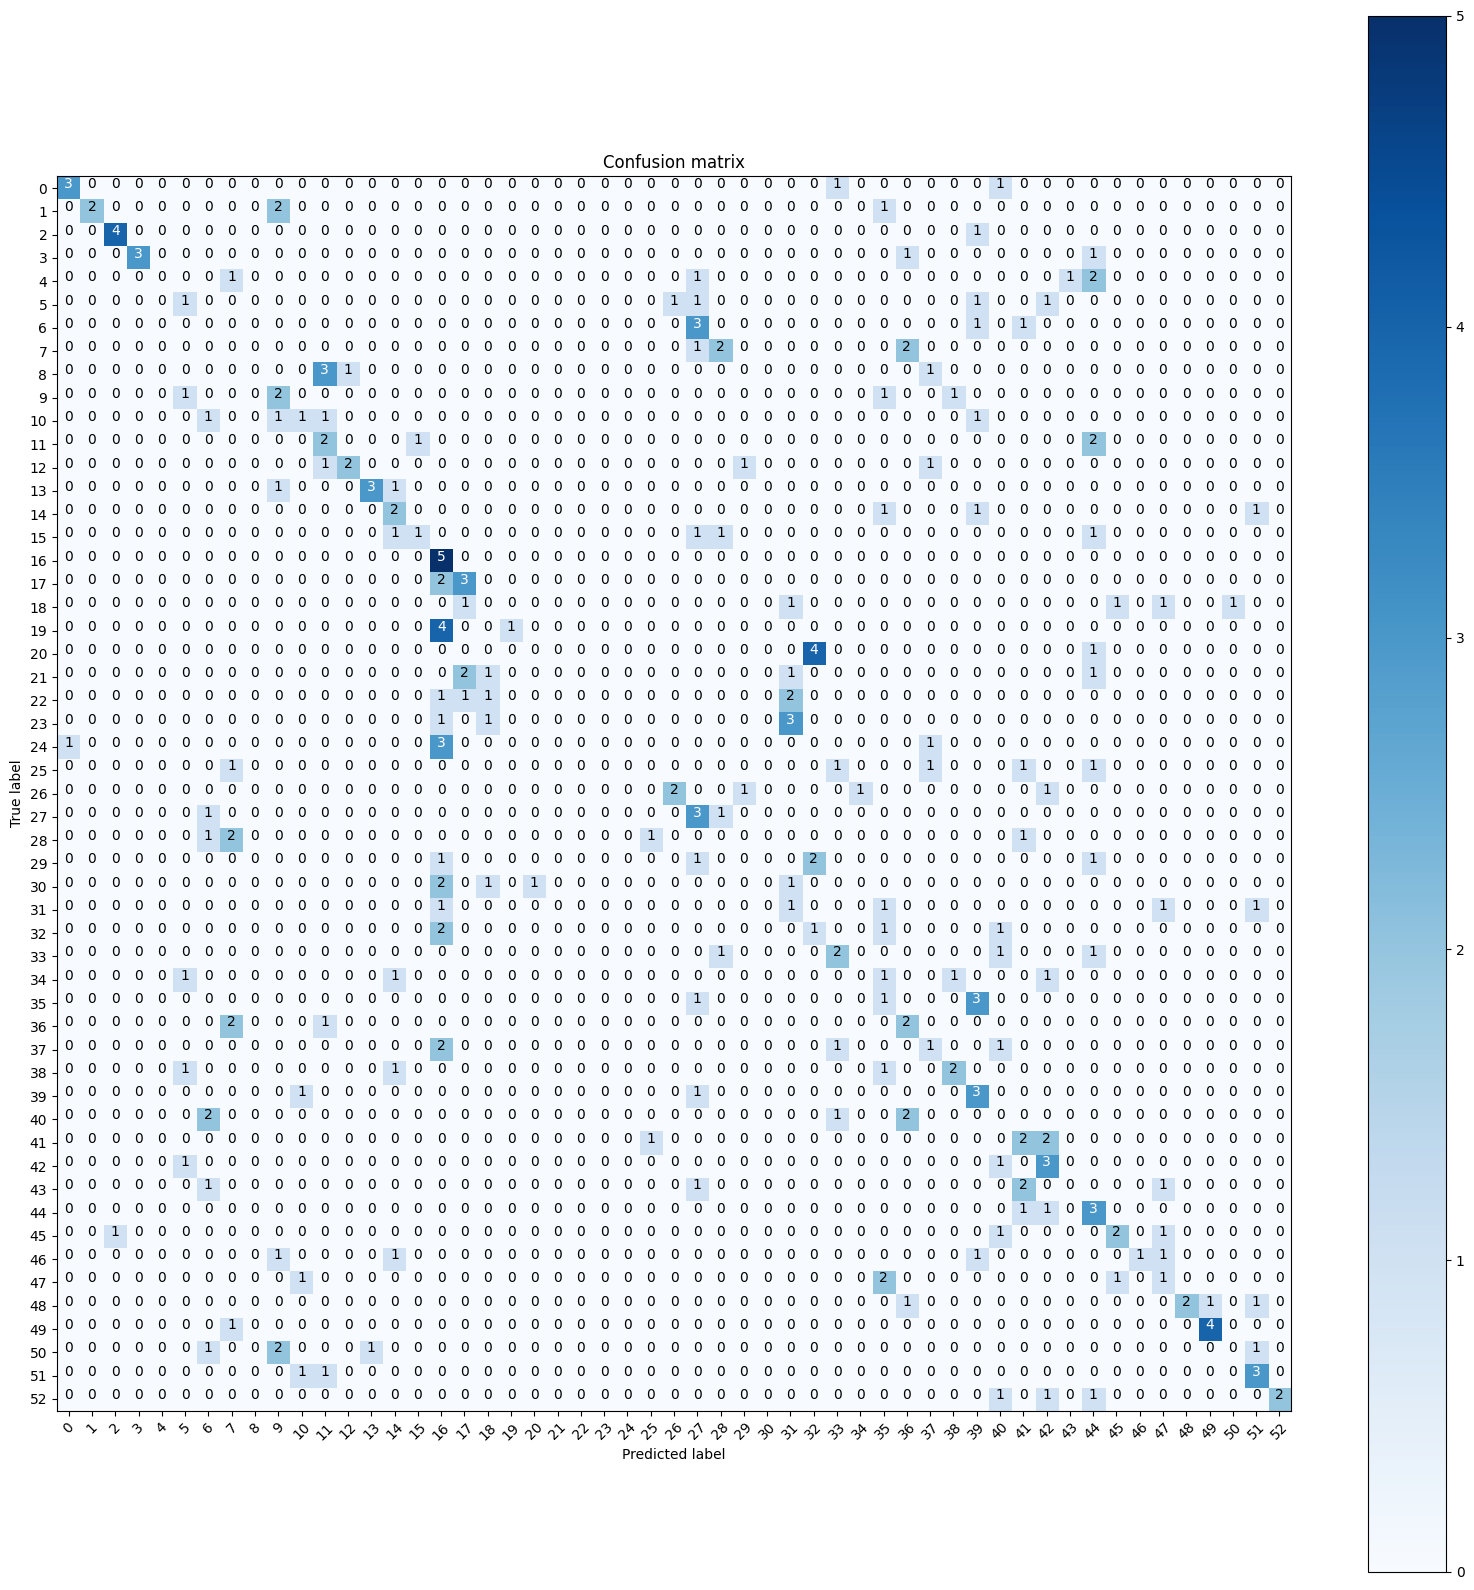

In [49]:
import itertools
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [16, 16]
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
# Y_pred = model.predict(img_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = y_test
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(53))

In [50]:
import tkinter as tk
from tkinter import filedialog
import numpy as np
import cv2
#import keras
import matplotlib.pyplot as plt

# Define the dictionary of card codes
code = {'ace of clubs': 0, 'ace of diamonds': 1, 'ace of hearts': 2, 'ace of spades': 3, 'eight of clubs': 4, 'eight of diamonds': 5, 'eight of hearts': 6, 'eight of spades': 7, 'five of clubs': 8, 'five of diamonds': 9, 'five of hearts': 10, 'five of spades': 11, 'four of clubs': 12, 'four of diamonds': 13, 'four of hearts': 14, 'four of spades': 15, 'jack of clubs': 16, 'jack of diamonds': 17, 'jack of hearts': 18, 'jack of spades': 19, 'joker': 20, 'king of clubs': 21, 'king of diamonds': 22, 'king of hearts': 23, 'king of spades': 24, 'nine of clubs': 25, 'nine of diamonds': 26, 'nine of hearts': 27, 'nine of spades': 28, 'queen of clubs': 29, 'queen of diamonds': 30, 'queen of hearts': 31, 'queen of spades': 32, 'seven of clubs': 33, 'seven of diamonds': 34, 'seven of hearts': 35, 'seven of spades': 36, 'six of clubs': 37, 'six of diamonds': 38, 'six of hearts': 39, 'six of spades': 40, 'ten of clubs': 41, 'ten of diamonds': 42, 'ten of hearts': 43, 'ten of spades': 44, 'three of clubs': 45, 'three of diamonds': 46, 'three of hearts': 47, 'three of spades': 48, 'two of clubs': 49, 'two of diamonds': 50, 'two of hearts': 51, 'two of spades': 52}

# Load the trained model
#model = keras.models.load_model('C:/Users/Menna/Downloads/Model')

# Define the GUI
class CardClassifierGUI:
    def __init__(self, master):
        self.master = master
        self.master.title("Card Classifier")
        
        # Define the components
        self.label = tk.Label(self.master, text="Upload an image of a playing card and click 'Classify' to predict the card.")
        self.label.pack()
        
        self.upload_button = tk.Button(self.master, text="Upload", command=self.upload_image)
        self.upload_button.pack()
        
        self.classify_button = tk.Button(self.master, text="Classify", command=self.classify_image)
        self.classify_button.pack()
        
        self.image_label = tk.Label(self.master)
        self.image_label.pack()
        
        self.result_label = tk.Label(self.master)
        self.result_label.pack()
        
        self.prob_label = tk.Label(self.master)
        self.prob_label.pack()
        
        # Initialize the image and result variables
        self.image = None
        self.result = None
        
    def upload_image(self):
        # Allow the user to select an image file
        file_path = filedialog.askopenfilename()   ##This method uses the askopenfilename() function from the filedialog module in Tkinter 
                                    #to open a file dialog box that allows the user to select an image file.
        # Load the image and display it in the GUI
        self.image = cv2.imread(file_path) ##CV2 library, which reads the image from the file path specified by file_path
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)##convert color from BGR to RGB
        self.image = cv2.resize(self.image, (200, 200))  ##The image is then resized to a smaller size of (200, 200) using the cv2.resize() function. 
                                     ##This is done to make the image smaller and easier to display in the GUI.
        
        plt.imshow(self.image)  ##display the image in a Matplotlib figure, 
        plt.axis('off')                  ##remove the axis and tick marks from the figure, which results in a cleaner and more visually appealing image display.
        plt.savefig('image.png')    ## saved to a file named 'image.png' using the plt.savefig() function.

        
        image = tk.PhotoImage(file='image.png')  ##PhotoImage() constructor in Tkinter.
        self.image_label.configure(image=image)  ## self.image_label widget to display the PhotoImage object by setting the image attribute to image.
        self.image_label.image = image
        
    def classify_image(self):
        if self.image is not None:
            # Preprocess the image
            X = np.array([self.image])
            X = X / 255.0
            
            # Make a prediction using the loaded model
            y_pred = Model.predict(X)
            
            # Display the predicted label and probability scores
            card_name = self.get_card_name(y_pred)
            
            self.result_label.configure(text="Predicted card: {}".format(card_name))
            self.prob_label.configure(text="Probability scores: {}".format(str(accuracy)))
            
    def get_card_name(self, y_pred):
        index = np.argmax(y_pred)
        name = list(code.keys())[list(code.values()).index(index)]
        return name

# Run the GUI
root = tk.Tk()
gui = CardClassifierGUI(root)
root.mainloop()

TclError: ignored